# Weights initialization

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import time as time

c:\Users\WINDOWS\anaconda3\envs\tensorflowEnv\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


## Load the MNIST dataset

In [6]:
# Define transformation
transform = transforms.ToTensor()

# Load MNIST dataset
train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [01:01<00:00, 162kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 181kB/s]
100%|██████████| 1.65M/1.65M [00:09<00:00, 166kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.34MB/s]


In [7]:
def mnist_to_dataframe(dataset):
    images = []
    labels = []
    
    for image, label in dataset:
        # Convert image tensor to a 1D list
        images.append(image.numpy().flatten())
        labels.append(label)
    
    # Convert lists to a Pandas DataFrame
    df = pd.DataFrame(images)
    df.insert(0, "label", labels)  # Insert labels as the first column
    return df

In [9]:
train_df = mnist_to_dataframe(train_dataset)
test_df = mnist_to_dataframe(test_dataset)

In [10]:
train_df.to_csv('../data/mnist_train.csv', index=False)
test_df.to_csv('../data/mnist_test.csv', index=False)

In [11]:
train_df.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
data = train_df.iloc[:, 1:]
labels = train_df.iloc[:, 0]

In [17]:
type(data.values)      

numpy.ndarray

In [18]:
dataT = torch.tensor(data.values).float()
labelsT = torch.tensor(labels.values).long()

In [19]:
dataT.shape

torch.Size([60000, 784])

In [20]:
train_dataset = TensorDataset(dataT, labelsT)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [55]:
test_data = torch.tensor(test_df.iloc[:, 1:].values).float()
test_labels = torch.tensor(test_df.iloc[:, 0].values).long()
test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0], shuffle=False)

In [56]:
def createMNISTModel():
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(784, 64)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, 32)
            self.out = nn.Linear(32, 10)

        def forward(self, x,doBN=False):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.out(x)
            return x

    net = Net()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    return net, loss_fn, optimizer    

In [57]:
stdevs = np.logspace(np.log10(0.0001), np.log10(10), num=25)
stdevs

array([1.00000000e-04, 1.61559810e-04, 2.61015722e-04, 4.21696503e-04,
       6.81292069e-04, 1.10069417e-03, 1.77827941e-03, 2.87298483e-03,
       4.64158883e-03, 7.49894209e-03, 1.21152766e-02, 1.95734178e-02,
       3.16227766e-02, 5.10896977e-02, 8.25404185e-02, 1.33352143e-01,
       2.15443469e-01, 3.48070059e-01, 5.62341325e-01, 9.08517576e-01,
       1.46779927e+00, 2.37137371e+00, 3.83118685e+00, 6.18965819e+00,
       1.00000000e+01])

In [58]:
# number of histogram bins for plotting distribution of weights
bins = 80

# initialize results output matrix
accresults = np.zeros(len(stdevs))
histodata = np.zeros((len(stdevs), 2, bins))

In [59]:
import importlib
import sys
sys.path.append('../utils')
import training
importlib.reload(training)
from training import trainTheM0del

In [60]:
startTime = time.process_time()
for idx , stdev in enumerate(stdevs):
    net, loss_fn, optimizer = createMNISTModel()

    # set all weights to random values with standard deviation stdev
    for p in net.parameters():
        p[1].data = torch.randn_like(p[1].data) * stdev

    losses,train_acc,test_acc = trainTheM0del(model=net,
                                            loss_function=loss_fn,
                                            optimizer=optimizer,
                                            train_loader=train_loader,
                                            test_loader=test_loader,
                                              num_epochs=10,
                                              isClassification=True)
                                              
    accresults[idx] = np.mean(test_acc[-3:])

    # collect all weights into a single vector and compute histogram
    tmpparams = np.array([])
    for p in net.parameters():
        tmpparams = np.concatenate((tmpparams, p[1].data.flatten().numpy()))

    # now compute their histogram
    y,x = np.histogram(tmpparams, bins=bins)
    histodata[idx,0,:] = (x[1:] + x[:-1]) / 2
    histodata[idx,1,:] = y  
    
    # status report
    print('Standard deviation: %f, Accuracy: %f' % (stdev, accresults[idx]))
    print('Elapsed time: %f seconds' % (time.process_time() - startTime))

Standard deviation: 0.000100, Accuracy: 96.453331
Elapsed time: 9.593750 seconds
Standard deviation: 0.000162, Accuracy: 95.253334
Elapsed time: 18.562500 seconds
Standard deviation: 0.000261, Accuracy: 96.153343
Elapsed time: 32.859375 seconds
Standard deviation: 0.000422, Accuracy: 96.413338
Elapsed time: 45.937500 seconds
Standard deviation: 0.000681, Accuracy: 96.296669
Elapsed time: 61.218750 seconds
Standard deviation: 0.001101, Accuracy: 96.260010
Elapsed time: 128.734375 seconds
Standard deviation: 0.001778, Accuracy: 96.576668
Elapsed time: 209.875000 seconds
Standard deviation: 0.002873, Accuracy: 96.359993
Elapsed time: 216.109375 seconds
Standard deviation: 0.004642, Accuracy: 96.400002
Elapsed time: 221.687500 seconds
Standard deviation: 0.007499, Accuracy: 96.183342
Elapsed time: 234.515625 seconds
Standard deviation: 0.012115, Accuracy: 96.696678
Elapsed time: 250.406250 seconds
Standard deviation: 0.019573, Accuracy: 96.266670
Elapsed time: 265.812500 seconds
Standard d

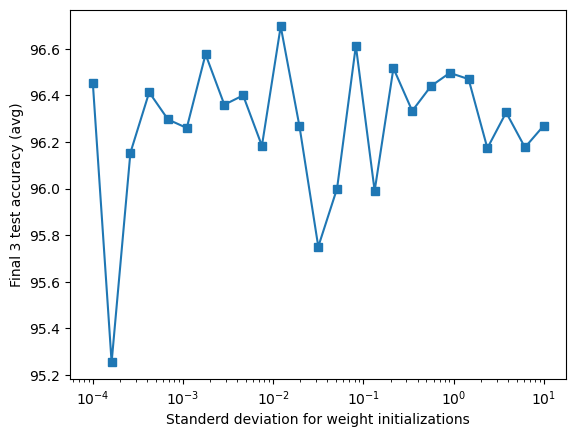

In [61]:
plt.plot(stdevs,accresults,'s-')
plt.xlabel('Standerd deviation for weight initializations')
plt.ylabel('Final 3 test accuracy (avg)')
plt.xscale('log')
plt.show()

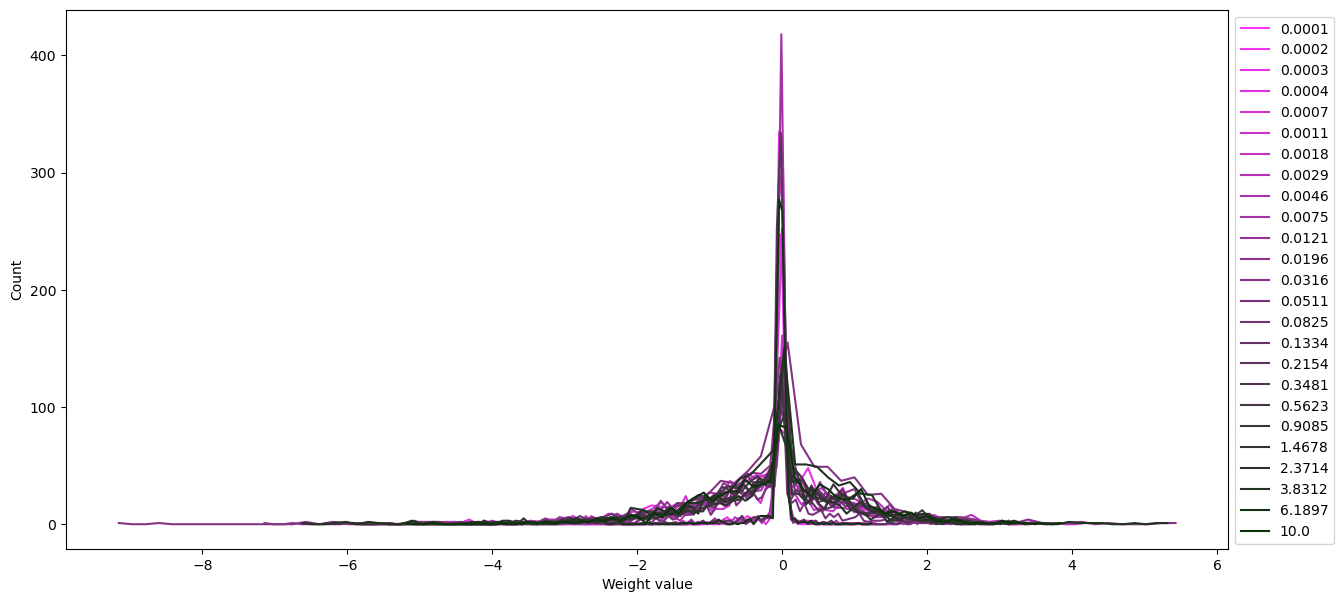

In [67]:
# show the weights distributions
plt.figure(figsize=(15,7))
for i in range(len(stdevs)):
    plt.plot(histodata[i,0,:],histodata[i,1,:],color=[1-i/len(stdevs),.2,1-i/len(stdevs)])

plt.xlabel('Weight value')
plt.ylabel('Count')
plt.legend(np.round(stdevs,4),loc='upper left',bbox_to_anchor = (1,1))
plt.show()

## Interpretations

 - In the first plot, we observe that higher accuracies are generally concentrated in the mid-range levels, suggesting that an optimal balance in weight initialization leads to better performance.

 - The accuracies for both high and low standard deviations are lower than those at intermediate levels. This is likely due to the `vanishing/exploding` gradient problem, where excessively small weights lead to negligible updates, while large weights cause instability.

 - In the distribution plots, we see that:
   
    - Very high standard deviation (std) results in wide and dispersed distributions (Black), leading to unstable training.

    - Very low std produces narrow and tightly packed distributions, restricting the learning capability of the network.

 - The  `Xavier (Glorot)` and `He (Kaiming)` initializations are designed to automatically optimize weight variability, ensuring that activations remain well-scaled throughout the network for efficient learning

In [4]:
help(nn.Linear)

Help on class Linear in module torch.nn.modules.linear:

class Linear(torch.nn.modules.module.Module)
 |  Linear(in_features: int, out_features: int, bias: bool = True, device=None, dtype=None) -> None
 |  
 |  Applies an affine linear transformation to the incoming data: :math:`y = xA^T + b`.
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.
 |  
 |  Args:
 |      in_features: size of each input sample
 |      out_features: size of each output sample
 |      bias: If set to ``False``, the layer will not learn an additive bias.
 |          Default: ``True``
 |  
 |  Shape:
 |      - Input: :math:`(*, H_{in})` where :math:`*` means any number of
 |        dimensions including none and :math:`H_{in} = \text{in\_features}`.
 |      - Output: :math:`(*, H_{out})` where all but the last dimension
 |        are the same shape as the input 